In [1]:
import pytest
import numpy as np
import setpath
from time_integrator import RK4Integrator
from nn_models import SingleParticleNNLagrangian, LagrangianModel
from dynamical_system import KeplerSystem
from trajectories import TrajectoryGenerator, PositionMonitor, InvariantMonitor, SingleParticleInvariantMonitor
from initializer import KeplerInitializer
from kepler import KeplerSolution
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Load models from disk and run trajectory generators

In [17]:
dt = 0.01
# final time
t_final = 128.0
dim = 3
# Dynamical system for exact integration

mass = 1.0
alpha = 1.0
excentricity = 0.8
energy = -0.1

kepler_solution = KeplerSolution(
    mass=mass,
    alpha=alpha,
    excentricity=excentricity,
    energy=energy,
)
initializer = KeplerInitializer(kepler_solution)

dynamical_system = KeplerSystem(mass, alpha)

monitors_nn = {}

for model_label in ["","rot"]:
    # load Lagrangian from disk
    filetag = "_" if model_label == "" else "_"+model_label+"_"
    model_filename = f"assets/trained_models/kepler/nn_lagrangian{filetag}5Aug2022/"
    nn_lagrangian = SingleParticleNNLagrangian.from_saved_model(model_filename)
    model = LagrangianModel(nn_lagrangian)
    # Monitors
    monitors_nn[model_label] = [PositionMonitor(dim),
                                InvariantMonitor(nn_lagrangian),
                                SingleParticleInvariantMonitor(dynamical_system)]
    # Run trajectory generators
    trajectory_generator_nn = TrajectoryGenerator(model,
                                                  initializer,
                                                  monitors_nn[model_label],
                                                  dt=dt,t_final=t_final)
    trajectory_generator_nn.run()
    T = trajectory_generator_nn.t

## Plot (projection of) trajectories

(3, 12801)
(3, 12801)


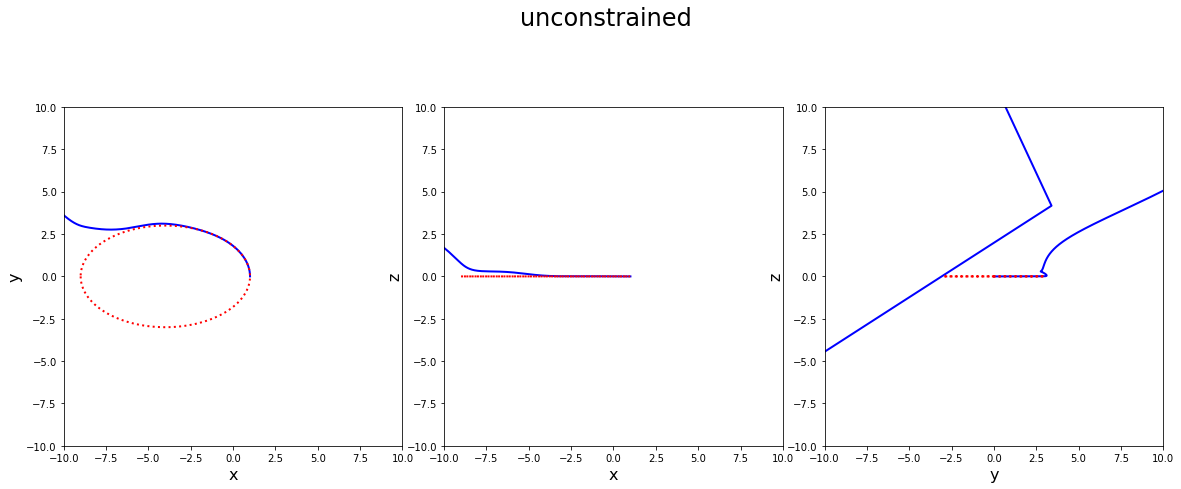

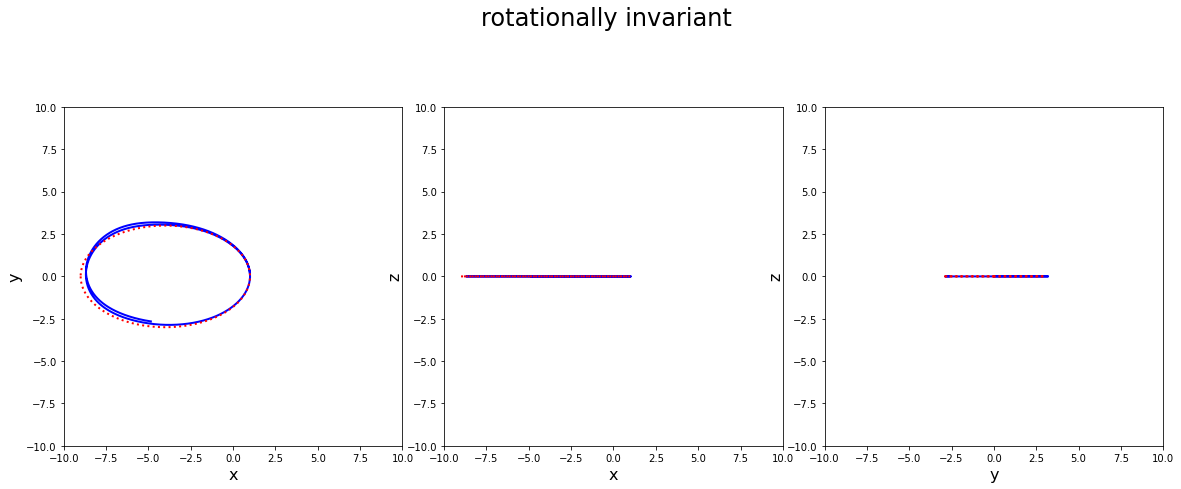

In [18]:
from ctypes import sizeof
from turtle import shape

title = {"":"unconstrained","rot":"rotationally invariant"}

for model_label in ["","rot"]:
    # Indices of space dimensions for projection
    fig, axs = plt.subplots(1,3,figsize=(16,8))
    fig.tight_layout()
    q_all = monitors_nn[model_label][0].value
    print (q_all.shape)
    idx = [[0,1],[0,2],[1,2]]
    labels = "xyz"
    Phi = np.arange(-np.pi,+np.pi,1.E-3)
    p_exact = kepler_solution.position(Phi)
    Phi_random = np.random.uniform(low=-np.pi, high=+np.pi,size=[100])
    p_exact_random = kepler_solution.position(Phi_random)
    for j in range(3):
        axs[j].set_xlim(-10,+10)
        axs[j].set_ylim(-10,+10)
        axs[j].set_aspect(1)
        axs[j].plot(q_all[idx[j][0],:],q_all[idx[j][1],:],linewidth=2,color="blue")
        axs[j].plot(p_exact[idx[j][0],:],p_exact[idx[j][1],:],linewidth=2,linestyle=":",color="red")
        axs[j].set_xlabel(labels[idx[j][0]],fontsize=16)
        axs[j].set_ylabel(labels[idx[j][1]],fontsize=16)
    fig.suptitle(title[model_label],fontsize=24)


## Plot invariants

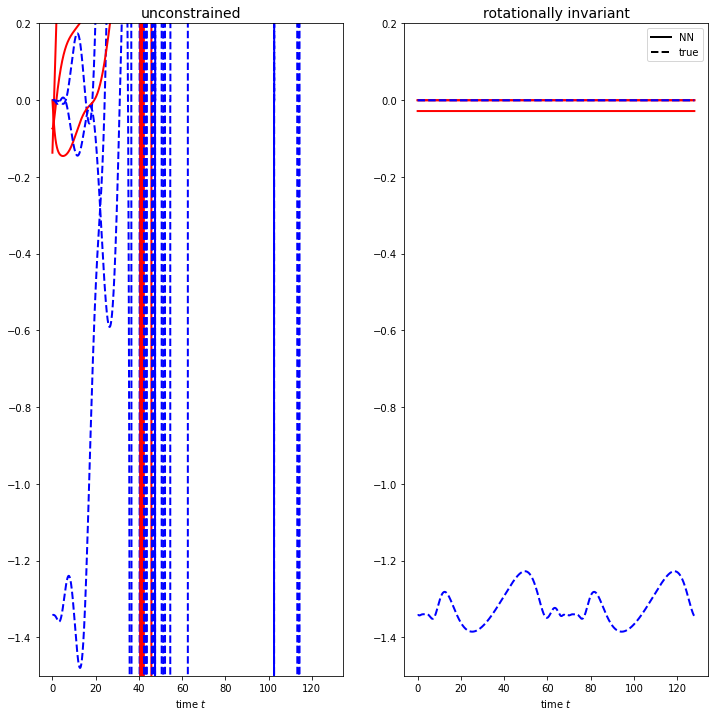

In [20]:
model_label_list = ["","rot"]

title = {"":"unconstrained",
         "rot":"rotationally invariant"}

fig, axs = plt.subplots(1, 2, figsize=(12,12))
for row in [0,1]:
    model_label = model_label_list[row]
    invariant = monitors_nn[model_label][1].value
    invariant_true = monitors_nn[model_label][2].value
    ax = axs[row]
    # Plot angular momentum
    for j in range(dim*(dim-1)//2):
        ax.plot(trajectory_generator_nn.t,invariant[j],linewidth=2,color="red")
        ax.plot(trajectory_generator_nn.t,invariant_true[j],linewidth=2,linestyle="--",color="blue")
    if row==1:
        ax.plot([],[],linewidth=2,color="black",label="NN")
        ax.plot([],[],linewidth=2,color="black",linestyle="--",label="true")
        ax.legend(loc="upper right")
    ax.set_xlabel("time $t$")
    ax.set_ylim(-1.5,+0.2)
    ax.set_title(title[model_label],fontsize=14)

plt.show()
